# Development Notebook

This notebook is intended to develop and test some code required for the **iWander** package.  Due to its nature it cannot be executed sequentially.

Some of the codes used here when mature are converted into routines in the dev/analysis.py 

In [379]:
import sys
sys.path.append("/home/local-python/lib/python3.5/site-packages")
sys.path.append("/home/iwander/.local/lib/python3.5/site-packages")
from iwander import *
from scipy.stats import norm as gaussian
from scipy import signal
import glob
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import astropy.coordinates as coord                                                                                                                                                                                                                                            
import astropy.units as u 

MSUN=2e30
GCONST=6.67e-11

## Global definitions

In [381]:
BASE_DIR="../"
%matplotlib inline
#%matplotlib nbagg

## Elements of surrogate objects

In [394]:
wobjs=pd.read_csv(BD+"wanderer.csv")
#wobjs=pd.read_csv(BD+"wanderer.csv.diagonal")
#wobjs=pd.read_csv(BD+"wanderer.csv.nodiagonal")
nominal=wobjs.iloc[0]
print(wobjs.columns)

Index(['i', 'qo', 'eo', 'inco', 'Wo', 'wo', 'Mo', 'to', 'muo', 'qasy', 'easy',
       'incasy', 'Wasy', 'wasy', 'Masy', 'tasy', 'mu', 'ting', 'xecl', 'yecl',
       'zecl', 'vxecl', 'vyecl', 'vzecl', 'xsky', 'ysky', 'zsky', 'vxsky',
       'vysky', 'vzsky', 'xgal', 'ygal', 'zgal', 'vxgal', 'vygal', 'vzgal',
       'RA', 'DEC', 'l', 'b', 'dummy'],
      dtype='object')


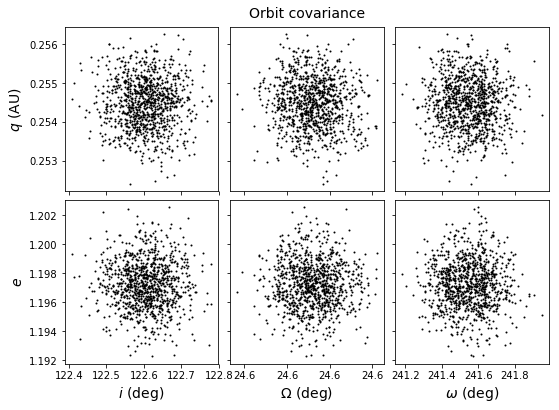

In [395]:
fig,axs=subPlots([1,1],l=0.12,b=0.2,ncols=3,dh=0.02,dw=0.02,figsize=(8,3))
args=dict(marker='o',color='k',ms=1,lw=0)
fsize=14

ax=axs[0][0]
ax.plot(wobjs.inco*RAD,wobjs.eo,**args)
ax.set_ylabel(r'$e$',fontsize=fsize)
ax.set_xlabel(r'$i$ (deg)',fontsize=fsize)

ax=axs[1][0]
ax.plot(wobjs.Wo*RAD,wobjs.eo,**args)
ax.set_xlabel(r'$\Omega$ (deg)',fontsize=fsize)
ax.set_yticklabels([])

ax=axs[2][0]
ax.plot(wobjs.wo*RAD,wobjs.eo,**args)
ax.set_xlabel(r'$\omega$ (deg)',fontsize=fsize)
ax.set_yticklabels([])

for ax in axs[0][0],axs[1][0],axs[2][0]:
    ax.tick_params(axis='both',which='major',labelsize=10)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax=axs[0][1]
ax.plot(wobjs.inco*RAD,wobjs.qo/AU,**args)
ax.set_ylabel(r'$q$ (AU)',fontsize=fsize)
ax.set_xticklabels([])

ax=axs[1][1]
ax.plot(wobjs.Wo*RAD,wobjs.qo/AU,**args)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax=axs[2][1]
ax.plot(wobjs.wo*RAD,wobjs.qo/AU,**args)
ax.set_xticklabels([])
ax.set_yticklabels([])

axs[1][1].set_title("Orbit covariance",position=(0.5,1.02),fontsize=14)

fig.savefig(FIGDIR+"wanderer-elements-diagonal.png")

## Position of the radiant

DEC =  34.147397388 0.0713627767597
RA =  280.153986922 0.196993761504
b =  16.9012410599 0.140051313863
l =  63.1642298349 0.114772359999
0.692898488252
-0.693038630723


Text(0.5,0.9,'Velocity at ingress: (U,V,W) = ($-11.320\\pm0.078$,$-22.380\\pm0.077$, $-7.618\\pm0.087$) pc')

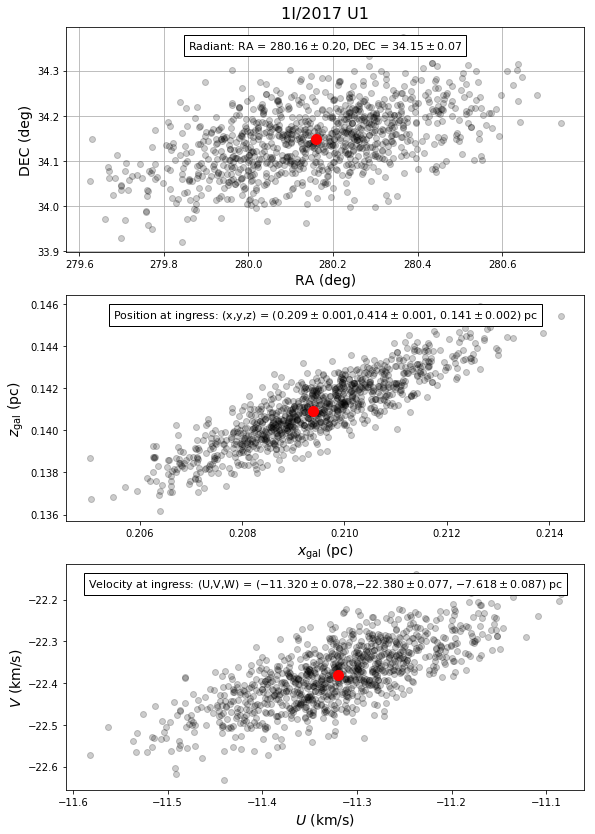

In [399]:
fig,axs=subPlots([1,1,1],dh=0.05,figsize=(9,4))

dec_error=wobjs.DEC.std()
ra_error=wobjs.RA.std()
dec_mean=wobjs.DEC.mean()
ra_mean=wobjs.RA.mean()

b_error=wobjs.b.std()
l_error=wobjs.l.std()
b_mean=wobjs.b.mean()
l_mean=wobjs.l.mean()

print("DEC = ",dec_mean,dec_error)
print("RA = ",ra_mean,ra_error)

print("b = ",b_mean,b_error)
print("l = ",l_mean,l_error)

ax=axs[0][-1]
ax.plot(wobjs.RA,wobjs.DEC,'ko',alpha=0.2)
ax.plot(wobjs.RA[0],wobjs.DEC[0],'ro',ms=10)

ax.set_xlabel("RA (deg)",fontsize=14)
ax.set_ylabel("DEC (deg)",fontsize=14)

ax.text(0.5,0.90,r"Radiant: RA = $%.2f\pm%.2f$, DEC = $%.2f\pm%.2f$"%(wobjs.RA[0],ra_error,
                                                                       wobjs.DEC[0],dec_error),
        transform=ax.transAxes,bbox=dict(fc='white'),fontsize=11,ha='center')

ax.set_title('1I/2017 U1',position=(0.5,1.01),fontsize=16)
ax.grid()

ax=axs[0][-2]
xecl=wobjs.xgal/PARSEC;yecl=wobjs.ygal/PARSEC;zecl=wobjs.zgal/PARSEC;
dx=xecl.std();dy=yecl.std();dz=zecl.std();

print(dx/xecl.mean()*100)

ax.plot(xecl,zecl,'ko',alpha=0.2)
ax.plot(xecl[0],zecl[0],'ro',ms=10)
ax.set_xlabel(r'$x_{\rm gal}$ (pc)',fontsize=14)
ax.set_ylabel(r'$z_{\rm gal}$ (pc)',fontsize=14)

ax.text(0.5,0.90,r"Position at ingress: (x,y,z) = ($%.3f\pm%.3f$,$%.3f\pm%.3f$, $%.3f\pm%.3f$) pc"%(xecl[0],dx,yecl[0],dy,zecl[0],dz),
        transform=ax.transAxes,bbox=dict(fc='white'),fontsize=11,ha='center')

ax=axs[0][-3]
vx=wobjs.vxgal;vy=wobjs.vygal;vz=wobjs.vzgal;
dvx=vx.std();dvy=vy.std();dvz=vz.std();

print(dvx/vx.mean()*100)

ax.plot(vx,vy,'ko',alpha=0.2)
ax.plot(vx[0],vy[0],'ro',ms=10)
ax.set_xlabel(r'$U$ (km/s)',fontsize=14)
ax.set_ylabel(r'$V$ (km/s)',fontsize=14)

ax.text(0.5,0.90,r"Velocity at ingress: (U,V,W) = ($%.3f\pm%.3f$,$%.3f\pm%.3f$, $%.3f\pm%.3f$) pc"%(vx[0],dvx,vy[0],dvy,vz[0],dvz),
        transform=ax.transAxes,bbox=dict(fc='white'),fontsize=11,ha='center')

## Development area

Since **iwander.py** library cannot be updated, while developing all global definitions and codes should be written in the following area

In [362]:
from matplotlib.ticker import FormatStrFormatter

#CONSTANTS
AU=1.496e8 #km
YEAR=365.25*86400
PARSEC=1/(1/3600.0*np.pi/180)*AU

DEG=np.pi/180
RAD=1/DEG

FIGDIR="figures/"

#ROUTINES
def figure(qax=True,**figopts):
    default=dict(qax=True)
    fig=plt.figure(**figopts)
    if qax:ax=fig.add_subplot(111)
    else:ax=None
    return fig,ax

def subPlots(panels,ncols=1,l=0.1,b=0.1,w=0.8,figsize=(8,6),dh=None,dw=None,fac=2.0):
    """
    Subplots
    """
    import numpy
    npanels=len(panels)
    spanels=sum(panels)

    # GET SIZE OF PANELS
    b=b/npanels
    if dh is None:dh=[b/2]*npanels
    elif type(dh) is not list:dh=[dh]*npanels
    else:
        dh+=[0]

    if dw is None:dw=w/5
        
    # EFFECTIVE PLOTTING REGION
    hall=(1-fac*b-sum(dh))
    hs=(hall*numpy.array(panels))/spanels
    fach=(1.0*max(panels))/spanels

    # SEE IF THERE IS MORE THAN ONE COLUMN
    wc=w/ncols if ncols>1 else w
    
    # CREATE AXES
    fig=plt.figure(figsize=(figsize[0],figsize[1]/fach))
    axs=[]
    
    bo=b
    axc=[]
    for i in range(npanels):
        ax=fig.add_axes([l,b,wc,hs[i]])
        axc+=[ax]
        b+=hs[i]+dh[i]
    axs+=[axc]
        
    b=bo
    if ncols>1:
        for j in range(ncols-1):
            b=bo
            l+=wc+dw
            axc=[]
            for i in range(npanels):
                ax=fig.add_axes([l,b,wc,hs[i]])
                axc+=[ax]
                b+=hs[i]+dh[i]
            axs+=[axc]
            
    return fig,axs

30857215014565.617


## Encounters

In [69]:
dataen=pd.read_csv(BD+"encounters.csv")

In [74]:
dmins=dataen.dmin[dataen.dmin<1000]

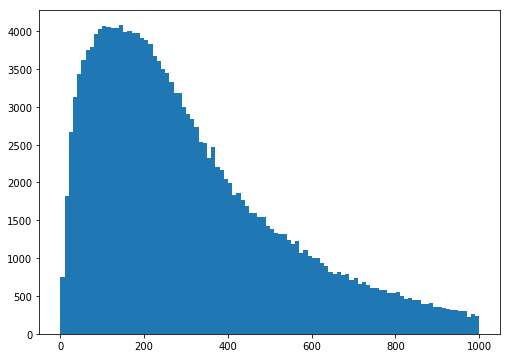

In [75]:
fig,axs=subPlots([1])

ax=axs[0][0]
rs=ax.hist(dmins,100)

In [65]:
datacan=pd.read_csv(BD+"candidates.csv")

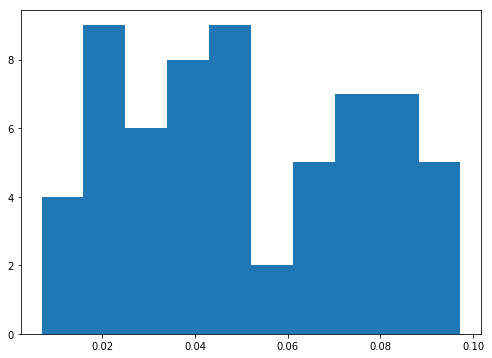

In [66]:
fig,axs=subPlots([1])

ax=axs[0][0]
rs=ax.hist(datacan.dmin/datacan.d)

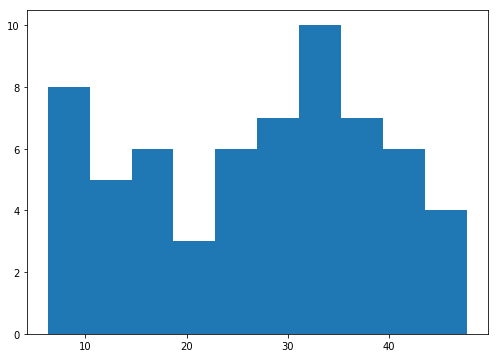

In [67]:
fig,axs=subPlots([1])
vrels=datacan.vrel[datacan.vrel<100]

ax=axs[0][0]
rs=ax.hist(vrels)

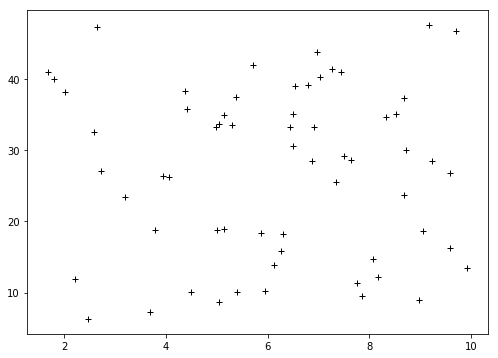

In [68]:
fig,axs=subPlots([1])

ax=axs[0][0]

ax.plot(datacan.dmin,datacan.vrel,'k+')

#ax.set_ylim((0,100))

In [78]:
vt=2*np.pi/(7*3600)*100

In [79]:
vt**2/100

6.2166820364634394e-06

In [80]:
vt

0.02493327502849042

## Ejection distributions

In [194]:
data=np.loadtxt("ejection-results.data")
aps=np.unique(data[:,0]);na=len(aps)
Mps=np.unique(data[:,1]);nM=len(Mps)
vmean_data=data[:,2].reshape(na,nM)
vstd_data=data[:,3].reshape(na,nM)
print("Number of data points: N(a) = %d, N(Mp) = %d"%(na,nM))
print("Values of ap:",aps)
print("Values of Mp:",Mps)

Number of data points: N(a) = 24, N(Mp) = 21
Values of ap: [ 0.5  0.7  0.9  1.1  1.3  1.5  1.7  1.9  2.1  2.3  2.5  2.7  2.9  3.1  3.3
  3.5  3.7  3.9  4.1  4.3  4.5  4.7  4.9  5.1]
Values of Mp: [ 0.0001      0.0001216   0.00014788  0.00017982  0.00021867  0.00026591
  0.00032336  0.00039322  0.00047818  0.00058148  0.00070711  0.00085987
  0.00104564  0.00127154  0.00154625  0.0018803   0.00228653  0.00278051
  0.00338122  0.0041117   0.005     ]


(0, 5)

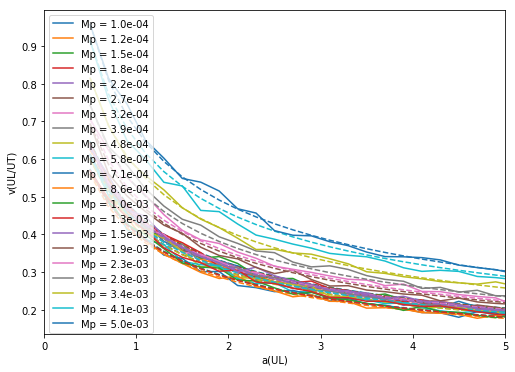

In [195]:
fig,axs=subPlots([1])

ax=axs[0][0]
fs=[]
for i,M in enumerate(Mps):
    line,=ax.plot(aps,vmean_data[:,i],label='Mp = %.1e'%Mps[i])
    f=vmean_data[0,i]*np.sqrt(aps[0])
    ax.plot(aps,f*np.sqrt(1/aps),'k--',color=line.get_color())
    fs+=[f]
    
ax.legend(loc='best')
ax.set_xlabel('a(UL)')
ax.set_ylabel('v(UL/UT)')
ax.set_xlim((0,5))

In [196]:
vs=[]
hs=[]
xs=[]
Mpps=[]
apps=[]
for file in glob.glob("data/*ap_5.0e+00*.data"):
    parts=file.split("--")
    Mp=float(parts[1].replace("Mp_",""))
    ap=float(parts[2].replace("ap_",""))
    vinfs=np.loadtxt(file)
    h,x=np.histogram(vinfs,30,normed=True)
    vmean=vinfs.mean()
    vstd=vinfs.std()
    vs+=[vinfs]
    hs+=[h]
    xs+=[x]
    Mpps+=[Mp]
    apps+=[ap]
    print("Velocity distribution for Mp = %e, ap = %e: vmean = %e, sigmav = %e"%(Mp,ap,vmean,vstd))
    
iargs=np.argsort(Mppfig=plt.figure()
ax=fig.gca()

c=ax.contourf(MPS,APS,vmean_data,200,cmap='spectral')
cb=fig.colorbar(c)
cb.set_label("$v_\infty$ (UL/UT)")

c=ax.contour(MPS,APS,vmean_data,colors='w')

ax.set_xlabel("$M_p$ ($U_M$)")
ax.set_ylabel("$a$ ($U_L$)")

ax.set_xscale("log")
#ax.set_yscale("log")s)
Mpps=np.array(Mpps)[iargs]
apps=np.array(apps)[iargs]
xs=np.array(xs)[iargs]
hs=np.array(hs)[iargs]
vs=np.array(vs)[iargs]

Velocity distribution for Mp = 1.000000e-02, ap = 5.000000e+00: vmean = 4.004175e-01, sigmav = 1.459988e-01
Velocity distribution for Mp = 1.000000e-03, ap = 5.000000e+00: vmean = 1.879614e-01, sigmav = 1.120181e-01
Velocity distribution for Mp = 5.000000e-03, ap = 5.000000e+00: vmean = 2.999224e-01, sigmav = 1.254320e-01


Text(0.5,1,'$a_p=0.5\\;u_L$')

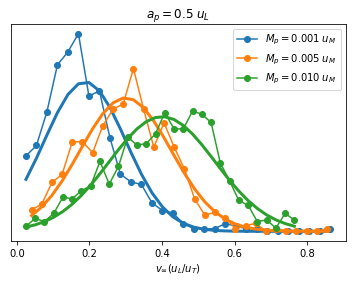

In [197]:
fig=plt.figure()
ax=fig.gca()

for i in range(len(vs)):
    Mp=Mpps[i]
    ap=apps[i]
    vinfs=vs[i]
    x=xs[i]
    h=hs[i]
    vmean=vinfs.mean()
    vstd=vinfs.std()
    xm=(x[1:]+x[:-1])/2
    line,=ax.plot(xm,h,'o-',label='$M_p=%.3f\;u_M$'%Mp)
    ax.plot(xm,h.sum()*(xm[1]-xm[0])*gaussian.pdf(xm,vmean,vstd),'-',lw=3,color=line.get_color())

ax.set_xlabel("$v_\infty$($u_L/u_T$)")
ax.set_yticks([])
ax.legend(loc='best')
ax.set_title("$a_p=%.1f\;u_L$"%aps[0])

In [198]:
UL=1*AU*1e3
UM=0.5*MSUN
UT=np.sqrt(UL**3/(GCONST*UM))
UV=UL/UT

In [199]:
print("UL=",UL,",UM=",UM)
print("UT=",UT,",UV=",UV)

UL= 149600000000.0 ,UM= 1e+30
UT= 7084912.21184 ,UV= 21115.2933907


In [200]:
MPS,APS=np.meshgrid(Mps,aps)
print(MPS.shape,APS.shape,vmean_data.shape)

(24, 21) (24, 21) (24, 21)


/home/local-python/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


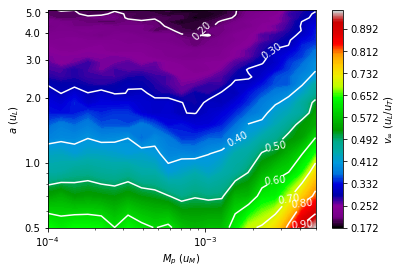

In [215]:
fig=plt.figure()
ax=fig.gca()

c=ax.contourf(MPS,APS,vmean_data,200,cmap='spectral')
cb=fig.colorbar(c)
cb.set_label("$v_\infty$ ($u_L/u_T$)")

c=ax.contour(MPS,APS,vmean_data,colors='w')
ax.clabel(c,inline=True,fmt="%.2f")

ax.set_xlabel("$M_p$ ($u_M$)")
ax.set_ylabel("$a$ ($u_L$)")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_yticks([0.5,1.0,2.0,3.0,4.0,5.0])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


Text(0,0.5,'$\\Delta v/v$')

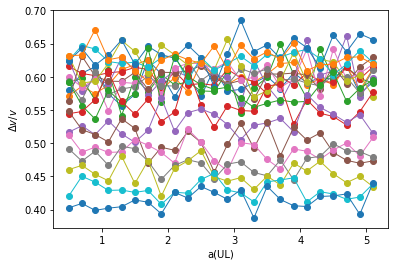

In [220]:
fig=plt.figure()
ax=fig.gca()

dvv=[]
for i,M in enumerate(Mps[::1]):
    ratio=vstd_data[:,i]/vmean_data[:,i]
    avg=ratio.mean()
    std=ratio.std()
    dvv+=[avg]
    line,=ax.plot(aps,ratio,label='Mp = %.1e'%Mps[i],marker='o',lw=1)
    #ax.axhspan(avg-std,avg+std,color=line.get_color(),alpha=0.3)

#ax.legend(loc='best')
ax.set_xlabel('a(UL)')
ax.set_ylabel('$\Delta v/v$')

Text(0.5,0,'$M_p$ ($u_M$)')

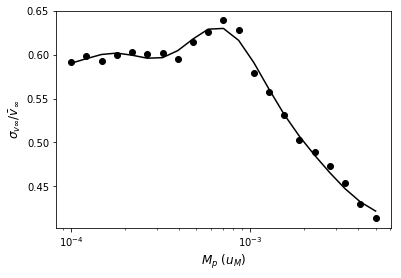

In [224]:
b,a=signal.butter(10,0.325)
sdv=signal.filtfilt(b,a,dvv,padlen=6)
fig=plt.figure()
ax=fig.gca()

ax.plot(Mps,dvv,'ko')
ax.plot(Mps,sdv,'k-')
#ax.plot(Mp,0.5*np.sqrt(1e-3/Mp))

ax.set_xscale('log')
ax.set_ylabel(r"$\sigma_{v\infty}/\bar{v}_\infty$",fontsize=12)
ax.set_xlabel(r"$M_p$ ($u_M$)",fontsize=12)

## Test particle integrations

In [279]:
data=pd.read_csv(BD+"cloud.csv")

In [280]:
data.columns

Index(['t', 'part0-R', 'part0-phi', 'part0-Z', 'part0-vR', 'part0-dphi',
       'part0-vZ', 'part0-x', 'part0-y', 'part0-z', 'part0-vx', 'part0-xy',
       'part0-vz', 'dummy'],
      dtype='object')

In [281]:
ts=data["t"]
Rs=data["part0-R"]
xs=data["part0-x"]
ys=data["part0-y"]
zs=data["part0-z"]

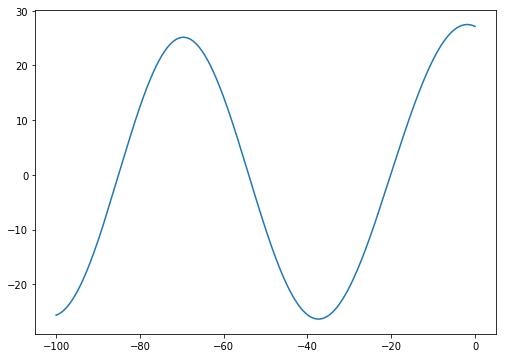

In [284]:
fig,axs=subPlots([1])
ax=axs[0][0]

ax.plot(ts/1e6,zs)

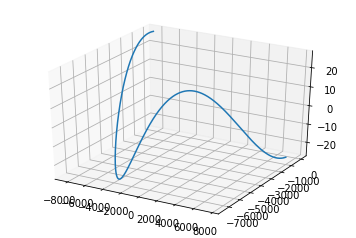

In [283]:
fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')

ax.plot(xs,ys,zs)

## Potential Progenitors

In [484]:
#encounters=pd.read_csv(BD+"encounters.csv")
candidates=pd.read_csv(BD+"candidates.csv")
progenitors=pd.read_csv(BD+"progenitors.csv")

In [485]:
progenitors.columns.values

array(['Pprob', 'nomdmin', 'nomtmin', 'mindmin', 'maxdmin', 'velrelmin',
       'velrelmax', 'n', 'postarx', 'postary', 'postarz', 'velstarx',
       'velstary', 'velstarz', 'posbodyperix', 'posbodyperiy',
       'posbodyperiz', 'postarperix', 'postarperiy', 'postarperiz', 'd',
       'dmin', 'tmin', 'vrelx', 'vrely', 'vrelz', 'vrel', 'hip',
       'tycho2_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag',
       'l', 'b', 'ecl_lon', 'ecl_lat', 'Vmag_Hip', 'ra_Hip', 'dec_Hip',
       'parallax_Hip', 'pmra_Hip', 'pmdec_Hip', 'ra_error_Hip',
       'dec_error_Hip', 'parallax_error_Hip', 'pmra_error_Hip',
       'pmdec_error_Hip', 'ra_dec_

In [487]:
progenitors[["hip","name_simbad","source","Pprob","parallax","parallax_Hip","dmin","nomtmin","nomdmin","mindmin","maxdmin","velrelmin"]].sort_values(by="nomdmin")

,hip,name_simbad,source,Pprob,parallax,parallax_Hip,dmin,nomtmin,nomdmin,mindmin,maxdmin,velrelmin
251,17288.0,HD_23121,gaia::hipparcos:simbad,2.670937e-03,10.025797,10.92,6.189000,-6663889.0,0.361482,0.273182,3.097451,15.034880
279,103749.0,HD_200325,::hipparcos:simbad,7.114002e-03,0.000000,19.29,2.456130,-4213392.0,0.488881,0.248265,3.624763,2.908484
253,63797.0,HD_113376,gaia::hipparcos:simbad,1.508244e-03,8.464321,10.59,2.204720,-2898464.0,1.497379,0.462947,7.285690,19.078830
219,104539.0,HD_201671,gaia::hipparcos:simbad,3.124535e-04,9.332084,1.61,7.615720,-10510500.0,1.693659,0.351912,24.193170,6.260796
257,18453.0,*_43_Per,::hipparcos:simbad,7.115348e-04,0.000000,24.51,2.046160,-958931.6,1.839711,1.269071,2.853047,36.727080
4,NaN,NaN,gaia:tycho::,3.327076e-07,4.862691,0.00,6.433290,-5651709.0,1.906126,1.676403,25.736060,35.930780
43,NaN,NaN,gaia:::,2.186065e-04,5.937269,0.00,4.939430,-4692470.0,1.950701,0.160445,27.297780,33.243180
204,6711.0,HD_8671,gaia::hipparcos:simbad,5.860729e-06,23.297285,24.21,1.941180,-1091738.0,1.960070,1.870949,2.178632,25.473760
45,NaN,NaN,gaia:tycho::,8.873826e-07,2.775291,0.00,26.170000,-7870572.0,2.009500,1.471863,23.035940,40.007770
31,NaN,NaN,gaia:::,6.139993e-04,10.820626,0.00,8.350540,-3766610.0,2.030607,0.866064,5.011008,24.100930


In [488]:
parallax=10.0
d=1/(parallax*1e-3)
print("Distance:",d)

Distance: 100.0


In [491]:
dist=0.3/3600*np.pi/180*100*206000
print("Binary distance:",dist)

Binary distance: 29.961485492569324


In [441]:
potential[["hip","tycho2_id","name_simbad","ra","ra_error","dec","dec_error","parallax","parallax_error","pmra","pmra_error","pmdec","pmdec_error","RV","eRV","l","b"]]

,hip,tycho2_id,name_simbad,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,RV,eRV,l,b
0,NaN,6978-911-1,NaN,347.674314,0.180093,-27.847338,0.144108,4.862691,0.323810,19.763900,0.905878,-16.610817,0.653017,32.760,0.629,25.231264,-67.685575
1,NaN,5907-1244-1,NaN,73.206504,0.113600,-19.917201,0.187257,16.127656,0.224871,37.815834,0.760327,-16.691572,0.633302,61.469,7.407,219.292801,-34.702594
2,NaN,5172-2349-1,NaN,300.992430,0.270462,-7.039355,0.142537,5.937269,0.436690,8.415726,1.654745,-21.093244,0.910812,16.613,2.072,34.861389,-19.316017
3,NaN,5855-2215-1,NaN,26.401155,0.542666,-18.059877,0.177087,3.837536,0.444167,17.460400,1.551883,-9.390947,0.554063,45.472,0.786,179.752669,-74.574715
4,NaN,7693-1161-1,NaN,147.149477,0.243751,-38.521808,0.236968,28.204604,0.380987,-100.365204,1.304336,6.482975,0.759690,67.929,0.781,268.052728,11.667269
5,NaN,9523-1571-1,NaN,293.353815,0.111309,-83.373595,0.165603,7.479796,0.260576,6.091397,0.627487,-37.089032,0.527859,45.659,2.209,310.324982,-28.141019
6,NaN,6961-156-1,NaN,333.676968,0.183766,-28.902393,0.153860,5.411970,0.310740,18.552904,1.017930,-21.615806,0.724449,16.344,0.820,20.619354,-55.519841
7,6711.0,NaN,HD_8671,21.578483,0.248077,43.457493,0.257165,23.297285,0.296188,108.637407,0.029468,-59.582758,0.026167,31.200,0.100,129.613374,-18.961340
8,76984.0,NaN,HD_140514,235.793322,0.183347,21.701364,0.181768,13.580618,0.258336,-36.867710,0.068109,-19.415125,0.075569,10.600,0.200,34.643129,50.716484
9,87382.0,NaN,HD_162826,267.808335,0.250138,40.072504,0.241083,29.587755,0.277417,-16.675547,0.025879,9.795455,0.030419,1.300,0.300,66.064020,28.060091


In [421]:
star=encounters[encounters["hip"]==43667.0]
star.dmin

208966    11.4723
Name: dmin, dtype: float64

In [449]:
data=pd.read_csv(BASE_DIR+"progenitors.csv")

In [450]:
len(data)

1

In [453]:
#data[["nomdmin","mindmin","maxdmin","hip","tycho2_id"]]
data

,nomdmin,nomtmin,mindmin,maxdmin,velrelmin,velrelmax,n,postarx,postary,postarz,...,ra_simbad,dec_simbad,pmra_simbad,pmdec_simbad,source,RAJ2000,DEJ2000,RV,eRV,CAT
0,10.67837,-9712328.0,3.956709,73.05565,40.50412,43.38089,319,91.902,-18.6707,-385.65,...,NaN,NaN,NaN,NaN,gaia:::,0.86342,-36.21017,47.317,1.036,RAVE-DR5.tsv


## Test Conversion

Here we are about to test the iwander routines that convert from observed properties into galactocentric properties

Star: TYC 6995-570-1

In [404]:
ra=0.86342775387840831
dec=-36.21023337545908305
par=2.51406002419760188
pmra=11.61562323735791225
pmdec=-7.08731846383377295
vr=47.31700000000000017

c1 = coord.ICRS(ra=ra*u.degree, dec=dec*u.degree,                                                                                                                                                                                                                    
                distance=(par*u.mas).to(u.pc, u.parallax()),                                                                                                                                                                                                                             
                pm_ra_cosdec=pmra*u.mas/u.yr,                                                                                                                                                                                                                 
                pm_dec=pmdec*u.mas/u.yr,                                                                                                                                                                                                                                                  
                radial_velocity=vr*u.km/u.s)  

In [405]:
c1.transform_to(coord.Galactocentric)

<Galactocentric Coordinate (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    ( 266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=( 11.1,  232.24,  7.25) km / s, z_sun=27.0 pc, roll=0.0 deg): (x, y, z) in pc
    (-8209.3564291, -19.11550775, -359.83547647)
 (v_x, v_y, v_z) in km / s
    ( 8.51491295,  208.15949305, -40.8191374)>

In [352]:
-1.57293*np.cos(0.380844*np.pi/180)

-1.5728952522432993

In [389]:
c1 = coord.ICRS(ra=88.59576199999999346*u.degree, dec=20.276173000*u.degree,                                                                                                                                                                                                                    
                distance=(115.43*u.mas).to(u.pc, u.parallax()),                                                                                                                                                                                                                             
                pm_ra_cosdec=-162.53999999999999204*u.mas/u.yr,                                                                                                                                                                                                                 
                pm_dec=-99.51000000000000512*u.mas/u.yr,                                                                                                                                                                                                                                                  
                radial_velocity=-13.47*u.km/u.s)  

In [395]:
co=c1.transform_to(coord.Galactocentric)

In [396]:
print(co)

<Galactocentric Coordinate (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    ( 266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=( 11.1,  232.24,  7.25) km / s, z_sun=27.0 pc, roll=0.0 deg): (x, y, z) in pc
    (-8308.51667619, -1.27277972,  26.61483052)
 (v_x, v_y, v_z) in km / s
    ( 24.77787473,  234.11288576,  0.03142402)>


In [400]:
print(co.v_x.value,co.v_y,co.v_z)

24.77787472783556 km / s 234.11288575649098 km / s 0.0314240199887278 km / s


In [402]:
np.array([co.v_x.value, co.v_y.value, co.v_z.value])-np.array([11.1,  232.24,  7.25])

array([ 13.67787473,   1.87288576,  -7.21857598])

## Exploring the data

In [382]:
gaia=pd.read_csv(BASE_DIR+"db/src/AstroRV.csv")

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,86,90,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [388]:
gaia[["hip","tycho2_id","source","pmra"]]

,hip,tycho2_id,source,pmra
0,NaN,55-72-1,gaia:tycho::,-1.572928
1,NaN,48-1138-1,gaia:tycho::,9.533592
2,NaN,55-1269-1,gaia:tycho::,-5.716453
3,NaN,55-1181-1,gaia:::,2.199605
4,NaN,55-1308-1,gaia:::,-25.334209
5,NaN,48-685-1,gaia:tycho::,-46.195261
6,NaN,48-120-1,gaia:tycho::,11.483705
7,NaN,48-1076-1,gaia:tycho::,19.802386
8,NaN,48-1215-1,gaia:::,-3.453327
9,NaN,55-551-1,gaia:::,-5.742096
